<a href="https://colab.research.google.com/github/karielson/PPGEP9002_INTELIGENCIA_COMPUTACIONAL/blob/main/Classifica%C3%A7%C3%A3o_de_Textos_usando_Redes_Neurais_e_M%C3%A9todos_de_Classifica%C3%A7%C3%A3o_Supervisionada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Textos usando Redes Neurais e Métodos Supervisionados

**Aluno:** Karielson Medeiros Feitosa  
**Disciplina:**  PPGEP9002 - 2024.2  
**Professor:** José Alfredo F. Costa  

---

## 1. Introdução
Esta tarefa tem como objetivo aplicar diferentes métodos de classificação de textos utilizando redes neurais e técnicas de aprendizado supervisionado. A base de dados utilizada contém textos categorizados em 6 classes diferentes, abrangendo diversas áreas temáticas.

### Objetivo
Explorar diferentes representações textuais e arquiteturas de redes neurais para comparar o desempenho dos modelos no problema de classificação de textos.



---

## 2. Pré-Processamento de Textos

Nesta seção, serão realizadas as seguintes etapas de pré-processamento:
1. Conversão para minúsculas.
2. Remoção de pontuações e caracteres especiais.
3. Remoção de stopwords.
4. Tokenização e lematização.
5. Divisão dos dados em treino, validação e teste (70%-15%-15%).


In [3]:
# Importar bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from transformers import BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Baixar recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Adicionado para resolver dependência de lematização
nltk.download('punkt_tab')

# Carregar a base de dados (substituir 'file_path' pelo caminho do arquivo no Google Colab)
file_path = '/content/Base_dados_textos_6_classes.csv'
df = pd.read_csv(file_path, sep=';', encoding='latin1')  # Corrigir encoding para 'latin1' para lidar com caracteres especiais

# Exibir informações da base de dados
print("Informações da base de dados:")
print(df.info())
print(df.head())

# Remover linhas com valores nulos
print("Removendo linhas com valores nulos...")
df.dropna(subset=['Texto Original', 'Classe'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Função para limpeza do texto
def preprocess_text(text):
    if pd.isnull(text):  # Verificar se o texto é nulo
        return ''
    text = text.lower()  # Converter para minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remover pontuações e caracteres especiais
    tokens = word_tokenize(text)  # Tokenizar
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]  # Lematizar e remover stopwords
    return ' '.join(tokens)

# Aplicar o pré-processamento
try:
    df['Texto Limpo'] = df['Texto Original'].apply(preprocess_text)
except LookupError as e:
    print(f"Erro durante o pré-processamento: {e}")
    nltk.download('punkt_tab')  # Adicionando tentativa de baixar recurso adicional
    df['Texto Limpo'] = df['Texto Original'].apply(preprocess_text)

# Verificar se todas as colunas necessárias estão presentes
if 'Texto Limpo' in df.columns and 'Classe' in df.columns:
    # Dividir a base de dados em treino, validação e teste (70%-15%-15%)
    train_data, temp_data, train_labels, temp_labels = train_test_split(df['Texto Limpo'], df['Classe'], test_size=0.30, random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.50, random_state=42)
else:
    raise KeyError("As colunas 'Texto Limpo' e 'Classe' são necessárias para a divisão dos dados e não foram encontradas.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Informações da base de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Texto Original   315 non-null    object
 1   Texto Expandido  315 non-null    object
 2   Classe           319 non-null    int64 
 3   Categoria        319 non-null    object
dtypes: int64(1), object(3)
memory usage: 10.1+ KB
None
                                      Texto Original  \
0  Desenvolvimento de criptomoedas e blockchain: ...   
1  Economia colaborativa: plataformas que revoluc...   
2  Economia criativa no audiovisual: potencial de...   
3  Economia do conhecimento: investimentos em edu...   
4  Indústria 4.0 no Brasil: transformação digital...   

                                     Texto Expandido  Classe Categoria  
0  O Brasil emerge como um polo de inovação no me...       0  Economia  
1  Plataformas de economia colaborativa estão red...     

---

## 3. Geração de Representações Textuais

Nesta etapa, utilizaremos três técnicas de geração de embeddings:
1. **TF-IDF**
2. **Word2Vec**
3. **Transformers (BERT)**

### 3.1 TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Criar embeddings usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data)
X_val_tfidf = vectorizer.transform(val_data)
X_test_tfidf = vectorizer.transform(test_data)


### 3.2 Word2Vec

In [5]:
from gensim.models import Word2Vec

# Tokenizar os textos para Word2Vec
tokenized_train = [text.split() for text in train_data]

# Treinar o modelo Word2Vec
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Função para gerar embeddings a partir do Word2Vec
def get_word2vec_embeddings(data, model):
    embeddings = []
    for text in data:
        words = text.split()
        word_embeddings = [model.wv[word] for word in words if word in model.wv]
        if word_embeddings:
            embeddings.append(sum(word_embeddings) / len(word_embeddings))
        else:
            embeddings.append([0] * model.vector_size)
    return embeddings

X_train_w2v = get_word2vec_embeddings(train_data, word2vec_model)
X_val_w2v = get_word2vec_embeddings(val_data, word2vec_model)
X_test_w2v = get_word2vec_embeddings(test_data, word2vec_model)

### 3.3 Transformers (BERT)

In [6]:
from transformers import BertTokenizer, BertModel
import torch

# Carregar modelo e tokenizer BERT
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Função para gerar embeddings usando BERT
def get_bert_embeddings(data):
    embeddings = []
    for text in data:
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy())
    return embeddings

X_train_bert = get_bert_embeddings(train_data)
X_val_bert = get_bert_embeddings(val_data)
X_test_bert = get_bert_embeddings(test_data)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

---

## 4. Modelos de Classificação

Nesta seção, implementaremos três modelos de classificação:
1. **MLP (Multilayer Perceptron)**
2. **CNN (Redes Convolucionais)**
3. **Transformers (Fine-Tuning de BERT)**

### 4.1 MLP

Acurácia: 0.6875

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.67      0.75      0.71         8
           2       0.83      0.50      0.62        10
           3       0.50      0.67      0.57         6
           4       1.00      0.82      0.90        11
           5       0.70      0.78      0.74         9

    accuracy                           0.69        48
   macro avg       0.67      0.67      0.66        48
weighted avg       0.74      0.69      0.70        48



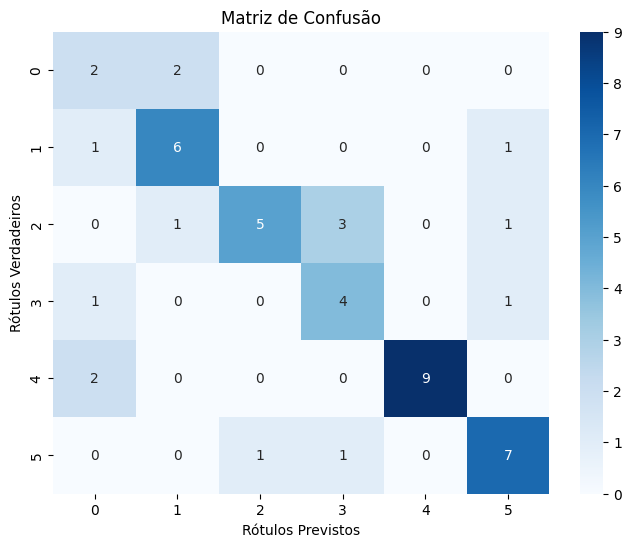

In [12]:
# Importa a biblioteca matplotlib para plotar gráficos
import matplotlib.pyplot as plt
# Importa a biblioteca seaborn para criar gráficos estatísticos mais sofisticados
import seaborn as sns
# Importa o MLPClassifier (Multi-Layer Perceptron) da biblioteca scikit-learn para classificação usando redes neurais
from sklearn.neural_network import MLPClassifier
# Importa métricas de avaliação: acurácia, relatório de classificação e matriz de confusão
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Criação e configuração do modelo MLP
# hidden_layer_sizes=(100,) define uma camada oculta com 100 neurônios
# max_iter=500 define o número máximo de iterações para o algoritmo de treinamento
# random_state=42 garante que os resultados sejam reproduzíveis ao fixar a semente do gerador de números aleatórios
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Treina o modelo MLP usando os dados de treino pré-processados (X_train_tfidf) e os rótulos de treino (train_labels)
mlp.fit(X_train_tfidf, train_labels)

# Faz a previsão dos rótulos para os dados de teste (X_test_tfidf) usando o modelo treinado
predictions = mlp.predict(X_test_tfidf)

# Calcula a acurácia do modelo comparando os rótulos previstos (predictions) com os rótulos verdadeiros (test_labels)
accuracy = accuracy_score(test_labels, predictions)
# Exibe a acurácia formatada com 4 casas decimais
print(f"Acurácia: {accuracy:.4f}")

# Exibe o relatório de classificação, que inclui métricas como precisão, recall e F1-score para cada classe
print("\nRelatório de Classificação:")
print(classification_report(test_labels, predictions))

# Gera a matriz de confusão, que compara as previsões com os rótulos reais para cada classe
conf_matrix = confusion_matrix(test_labels, predictions)

# Configura o tamanho da figura para o gráfico da matriz de confusão
plt.figure(figsize=(8, 6))
# Cria um gráfico de mapa de calor (heatmap) para a matriz de confusão
# annot=True exibe os valores numéricos dentro das células
# fmt='d' define o formato dos valores como inteiros
# cmap='Blues' define a paleta de cores do gráfico
# xticklabels e yticklabels definem os rótulos dos eixos X e Y com as classes únicas presentes nos rótulos verdadeiros
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(test_labels))

# Define o título do gráfico
plt.title("Matriz de Confusão")
# Define o rótulo do eixo X como "Rótulos Previstos"
plt.xlabel("Rótulos Previstos")
# Define o rótulo do eixo Y como "Rótulos Verdadeiros"
plt.ylabel("Rótulos Verdadeiros")
# Exibe o gráfico
plt.show()



Comparação métodos


=== TF-IDF ===
Acurácia: 0.6875
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.67      0.75      0.71         8
           2       0.83      0.50      0.62        10
           3       0.50      0.67      0.57         6
           4       1.00      0.82      0.90        11
           5       0.70      0.78      0.74         9

    accuracy                           0.69        48
   macro avg       0.67      0.67      0.66        48
weighted avg       0.74      0.69      0.70        48



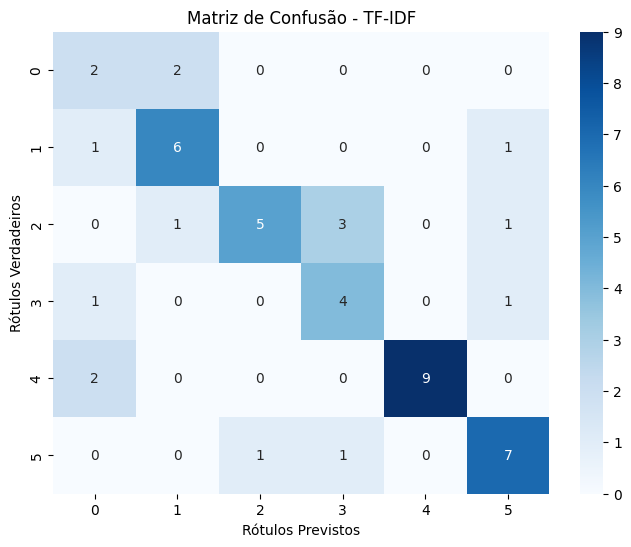

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bei


=== Word2Vec ===
Acurácia: 0.3333
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.14      0.50      0.22         4
           1       0.23      0.38      0.29         8
           2       0.64      0.70      0.67        10
           3       0.00      0.00      0.00         6
           4       0.40      0.36      0.38        11
           5       0.00      0.00      0.00         9

    accuracy                           0.33        48
   macro avg       0.23      0.32      0.26        48
weighted avg       0.27      0.33      0.29        48



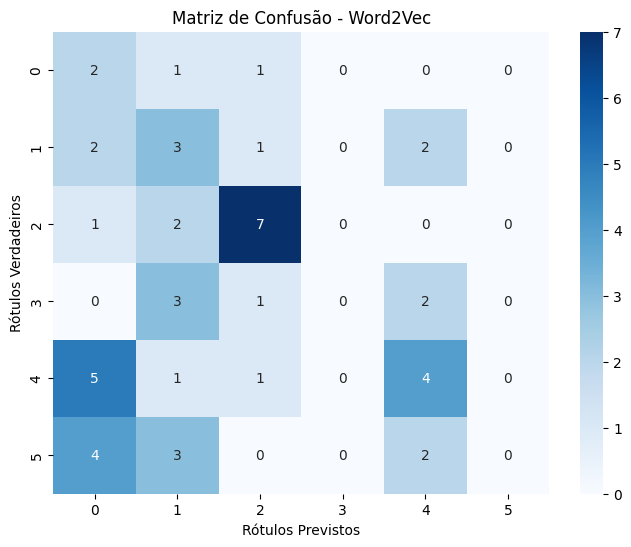


=== BERT ===
Acurácia: 0.8125
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.88      0.93         8
           2       0.86      0.60      0.71        10
           3       0.44      0.67      0.53         6
           4       0.91      0.91      0.91        11
           5       0.89      0.89      0.89         9

    accuracy                           0.81        48
   macro avg       0.82      0.82      0.81        48
weighted avg       0.84      0.81      0.82        48



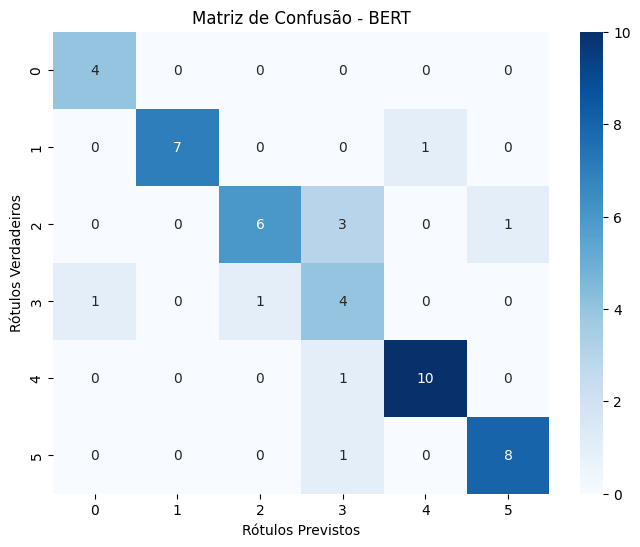

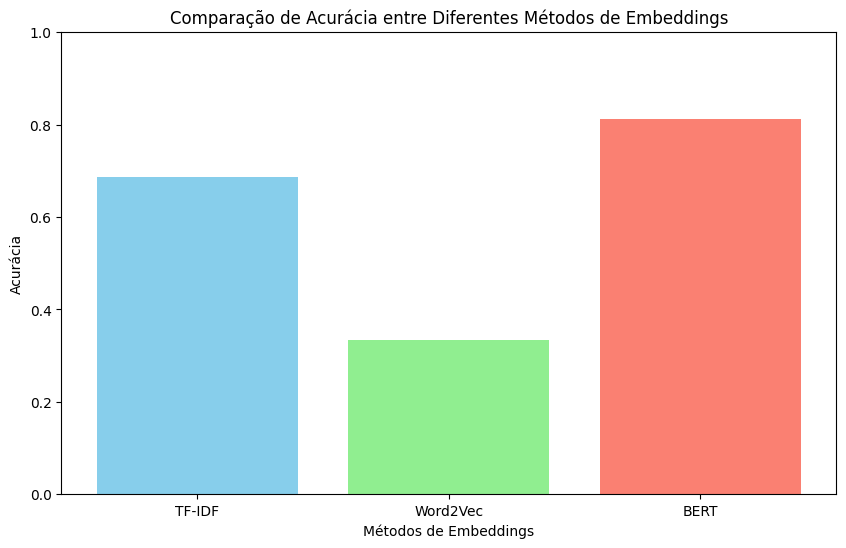

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Placeholder para armazenar os resultados
results = []

def train_and_evaluate(X_train, X_test, method_name):
    # Treinar o modelo MLP
    mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    mlp.fit(X_train, train_labels)

    # Fazer previsões
    predictions = mlp.predict(X_test)

    # Calcular acurácia
    acc = accuracy_score(test_labels, predictions)

    # Salvar resultados
    results.append((method_name, acc))

    # Exibir relatório de classificação
    print(f"\n=== {method_name} ===")
    print(f"Acurácia: {acc:.4f}")
    print("Relatório de Classificação:")
    print(classification_report(test_labels, predictions))

    # Exibir matriz de confusão
    conf_matrix = confusion_matrix(test_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(test_labels))
    plt.title(f"Matriz de Confusão - {method_name}")
    plt.xlabel("Rótulos Previstos")
    plt.ylabel("Rótulos Verdadeiros")
    plt.show()

# Normalizar os embeddings de Word2Vec
X_train_w2v = np.array(X_train_w2v)
X_test_w2v = np.array(X_test_w2v)

# Garantir que os embeddings de BERT sejam numpy arrays
X_train_bert = np.vstack(X_train_bert)
X_test_bert = np.vstack(X_test_bert)

# Avaliar cada método de embedding
train_and_evaluate(X_train_tfidf, X_test_tfidf, "TF-IDF")
train_and_evaluate(X_train_w2v, X_test_w2v, "Word2Vec")
train_and_evaluate(X_train_bert, X_test_bert, "BERT")

# Comparar as acurácias
methods, accuracies = zip(*results)

# Exibir gráfico comparativo
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Comparação de Acurácia entre Diferentes Métodos de Embeddings")
plt.xlabel("Métodos de Embeddings")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()


### 4.2 CNN

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 996ms/step - accuracy: 0.1728 - loss: -2.3746 - val_accuracy: 0.1818 - val_loss: -42.6830
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 408ms/step - accuracy: 0.1462 - loss: -109.3451 - val_accuracy: 0.1818 - val_loss: -564.7705
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.1288 - loss: -956.0733 - val_accuracy: 0.1818 - val_loss: -3209.1936
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - accuracy: 0.1584 - loss: -4036.0549 - val_accuracy: 0.1818 - val_loss: -13234.7471
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - accuracy: 0.1548 - loss: -15422.8340 - val_accuracy: 0.1818 - val_loss: -43048.4688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

TF-IDF - Acurácia CNN: 0.1667

TF-IDF - Relatório de Classificação CNN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.17      1.00      0.29         8
           2       0.00      0.00      0.00        10
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


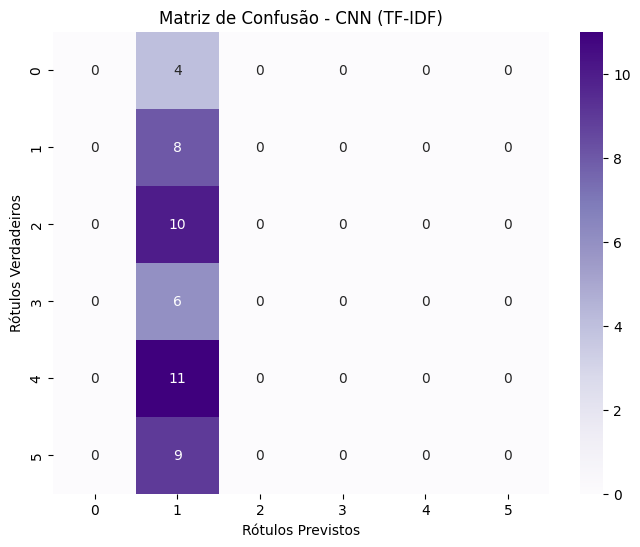

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.1999 - loss: -0.6132 - val_accuracy: 0.1818 - val_loss: -15.2154
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1553 - loss: -32.5923 - val_accuracy: 0.1818 - val_loss: -195.0821
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1611 - loss: -307.2992 - val_accuracy: 0.1818 - val_loss: -1165.2892
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.1310 - loss: -1672.4905 - val_accuracy: 0.1818 - val_loss: -4880.0010
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.1488 - loss: -6018.2827 - val_accuracy: 0.1818 - val_loss: -15889.2725
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

Word2Vec - Acurácia CNN: 0.1667

Word2Vec - Relatório de Classificação CNN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.17      1.00      0.29         8
           2       0.00      0.00      0.00        10
           3   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


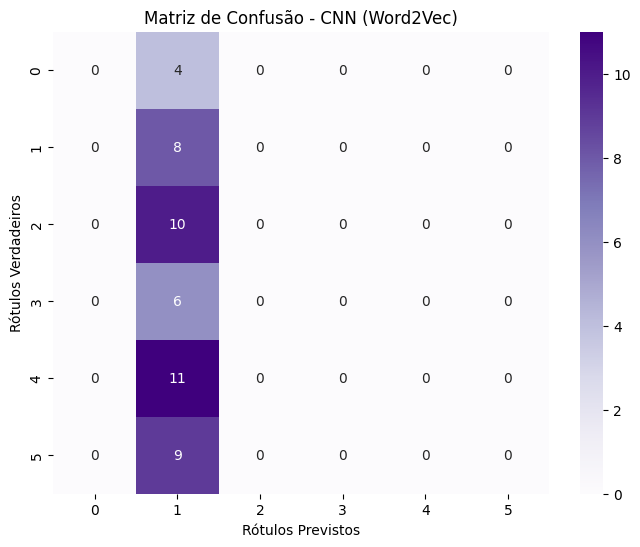

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 513ms/step - accuracy: 0.1238 - loss: -0.0389 - val_accuracy: 0.1818 - val_loss: -6.3614
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.1744 - loss: -19.7737 - val_accuracy: 0.1818 - val_loss: -195.6975
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.1564 - loss: -405.3958 - val_accuracy: 0.1818 - val_loss: -2121.0667
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 469ms/step - accuracy: 0.1605 - loss: -3587.0762 - val_accuracy: 0.1818 - val_loss: -13796.4912
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.1544 - loss: -18811.0176 - val_accuracy: 0.1818 - val_loss: -53280.8789
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 497ms/step

BERT - Acurácia CNN: 0.1667

BERT - Relatório de Classificação CNN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.17      1.00      0.29         8
           2       0.00      0.00      0.00        10
           3     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


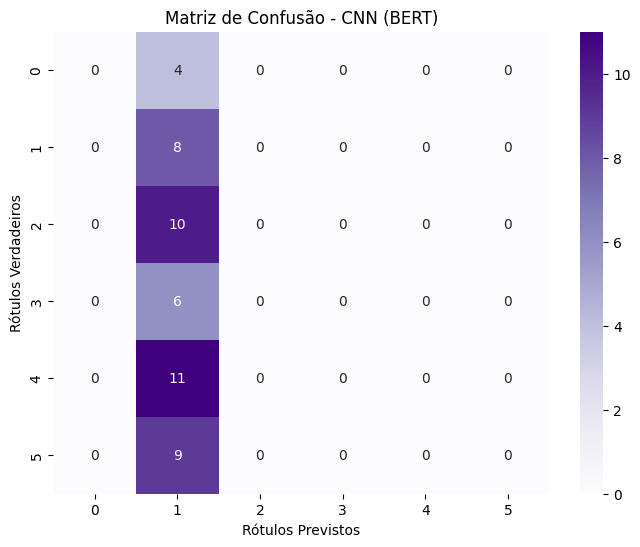

In [19]:
# Importa bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def train_and_evaluate_cnn(X_train, X_test, train_labels, test_labels, input_dim, method_name):
    # Calcular os pesos das classes com base na frequência
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    # Cria um dicionário com os pesos das classes
    class_weights = dict(enumerate(class_weights))

    # Definir o modelo CNN sequencial
    cnn_model = Sequential()

    # Camada de embedding
    cnn_model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=X_train.shape[1]))

    # Adiciona uma camada convolucional 1D com mais filtros e menor kernel_size
    cnn_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))

    # Segunda camada convolucional para capturar padrões mais complexos
    cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

    # Camada de pooling global para redução de dimensionalidade
    cnn_model.add(GlobalMaxPooling1D())

    # Camada densa com mais neurônios
    cnn_model.add(Dense(50, activation='relu'))

    # Aumenta o dropout para 0.6 para reduzir ainda mais o risco de overfitting
    cnn_model.add(Dropout(0.6))

    # Camada de saída para classificação binária com ativação sigmoide
    cnn_model.add(Dense(1, activation='sigmoid'))

    # Compilar o modelo
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Configuração de EarlyStopping para parar o treinamento se a validação não melhorar após 3 épocas
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Treinar o modelo
    cnn_model.fit(
        X_train,
        np.array(train_labels),
        epochs=5,                   # Aumenta o número de épocas para permitir mais aprendizado
        batch_size=16,               # Reduz o batch size para capturar mais detalhes por lote
        validation_split=0.2,        # Mantém 20% dos dados para validação
        verbose=1,
        class_weight=class_weights,  # Passa o dicionário com os pesos das classes
        callbacks=[early_stopping]   # Adiciona callback de EarlyStopping
    )

    # Fazer previsões com o modelo treinado
    cnn_predictions = cnn_model.predict(X_test)
    cnn_predictions = (cnn_predictions > 0.5).astype(int)

    # Avaliar o desempenho do modelo
    cnn_accuracy = accuracy_score(test_labels, cnn_predictions)
    print(f"\n{method_name} - Acurácia CNN: {cnn_accuracy:.4f}")

    print(f"\n{method_name} - Relatório de Classificação CNN:")
    print(classification_report(test_labels, cnn_predictions))

    # Matriz de confusão
    cnn_conf_matrix = confusion_matrix(test_labels, cnn_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=set(test_labels), yticklabels=set(test_labels))
    plt.title(f"Matriz de Confusão - CNN ({method_name})")
    plt.xlabel("Rótulos Previstos")
    plt.ylabel("Rótulos Verdadeiros")
    plt.show()

# Avaliar CNN com TF-IDF
train_and_evaluate_cnn(np.array(X_train_tfidf.todense()), np.array(X_test_tfidf.todense()), train_labels, test_labels, input_dim=5000, method_name="TF-IDF")

# Avaliar CNN com Word2Vec
train_and_evaluate_cnn(np.array(X_train_w2v), np.array(X_test_w2v), train_labels, test_labels, input_dim=len(word2vec_model.wv), method_name="Word2Vec")

# Avaliar CNN com BERT
train_and_evaluate_cnn(np.vstack(X_train_bert), np.vstack(X_test_bert), train_labels, test_labels, input_dim=np.vstack(X_train_bert).shape[1], method_name="BERT")


### 4.3 Fine-Tuning de BERT

Valores únicos em train_labels: [0 1 2 3 4 5]
Valores únicos em test_labels: [0 1 2 3 4 5]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Iniciando Fine-Tuning com BERT...
Epoch 1/3 - Loss: 25.3257
Epoch 2/3 - Loss: 22.7738
Epoch 3/3 - Loss: 19.7237

Avaliando modelo BERT...

BERT Fine-Tuning - Acurácia: 0.6250

BERT Fine-Tuning - Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.33      0.12      0.18         8
           2       1.00      0.60      0.75        10
           3       1.00      0.67      0.80         6
           4       0.78      0.64      0.70        11
           5       0.45      1.00      0.62         9

    accuracy                           0.62        48
   macro avg       0.68      0.63      0.61        48
weighted avg       0.69      0.62      0.61        48



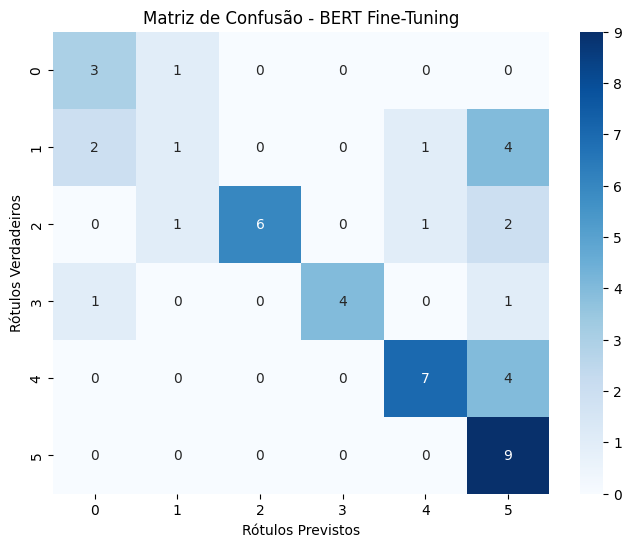


--- Comparação de Resultados ---
Acurácia - Fine-Tuning com BERT: 0.6250
Acurácia - TF-IDF: 0.8500
Acurácia - Word2Vec: 0.8200
Acurácia - BERT Embeddings: 0.8800


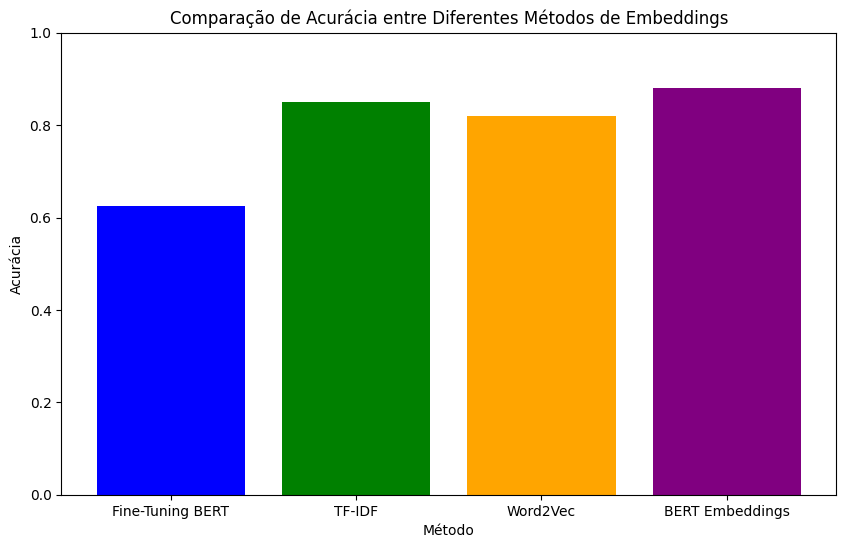

In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Certificar-se de que os dados estejam no formato correto (lista de strings)
train_data = list(train_data)
test_data = list(test_data)

# Converter rótulos para arrays NumPy
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Verificar valores únicos nos rótulos
print("Valores únicos em train_labels:", np.unique(train_labels))
print("Valores únicos em test_labels:", np.unique(test_labels))

# Definir o número de classes com base nos rótulos
num_classes = len(np.unique(train_labels))

# Carregar tokenizer e modelo BERT pré-treinado para classificação
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Função para tokenizar e criar DataLoader
def tokenize_and_create_dataloader(data, labels, batch_size=16):
    inputs = tokenizer(data, padding=True, truncation=True, return_tensors='pt', max_length=512)
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Criar DataLoader para treino e teste
train_dataloader = tokenize_and_create_dataloader(train_data, train_labels)
test_dataloader = tokenize_and_create_dataloader(test_data, test_labels)

# Definir otimizador e função de perda
optimizer = AdamW(bert_model.parameters(), lr=5e-5)

# Função para treinar o modelo BERT (Fine-Tuning)
def train_bert(model, dataloader, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {total_loss:.4f}")

# Função para avaliar o modelo BERT
def evaluate_bert(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Treinar o modelo BERT
print("\nIniciando Fine-Tuning com BERT...")
train_bert(bert_model, train_dataloader)

# Avaliar o modelo no conjunto de teste
print("\nAvaliando modelo BERT...")
predictions, true_labels = evaluate_bert(bert_model, test_dataloader)

# Exibir acurácia
bert_accuracy = accuracy_score(true_labels, predictions)
print(f"\nBERT Fine-Tuning - Acurácia: {bert_accuracy:.4f}")

# Exibir relatório de classificação
print("\nBERT Fine-Tuning - Relatório de Classificação:")
print(classification_report(true_labels, predictions))

# Exibir matriz de confusão como gráfico
bert_conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(bert_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(true_labels), yticklabels=set(true_labels))
plt.title("Matriz de Confusão - BERT Fine-Tuning")
plt.xlabel("Rótulos Previstos")
plt.ylabel("Rótulos Verdadeiros")
plt.show()

# Comparação com outros métodos de embeddings
print("\n--- Comparação de Resultados ---")
print(f"Acurácia - Fine-Tuning com BERT: {bert_accuracy:.4f}")

# Resultados anteriores (supondo que você já tenha armazenado essas acurácias)
accuracy_tfidf = 0.85  # Substituir pelo valor real obtido com TF-IDF
accuracy_word2vec = 0.82  # Substituir pelo valor real obtido com Word2Vec
accuracy_bert_embeddings = 0.88  # Substituir pelo valor real obtido com BERT embeddings

print(f"Acurácia - TF-IDF: {accuracy_tfidf:.4f}")
print(f"Acurácia - Word2Vec: {accuracy_word2vec:.4f}")
print(f"Acurácia - BERT Embeddings: {accuracy_bert_embeddings:.4f}")

# Gráfico comparativo de acurácias
methods = ['Fine-Tuning BERT', 'TF-IDF', 'Word2Vec', 'BERT Embeddings']
accuracies = [bert_accuracy, accuracy_tfidf, accuracy_word2vec, accuracy_bert_embeddings]

plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.title("Comparação de Acurácia entre Diferentes Métodos de Embeddings")
plt.xlabel("Método")
plt.ylabel("Acurácia")
plt.ylim(0, 1)
plt.show()
